In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np

import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import torch.utils.data
import math


class LayerNorm(nn.Module):
    """
    layer normalization
    Simple layer norm object optionally used with the convolutional encoder.
    """

    def __init__(self, feature_dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones((feature_dim,)))
        self.register_parameter("gamma", self.gamma)
        self.beta = nn.Parameter(torch.zeros((feature_dim,)))
        self.register_parameter("beta", self.beta)
        self.eps = eps

    def forward(self, x):
        # x: [batch_size, embed_dim]
        # normalize for each embedding
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # output shape is the same as x
        # Type not match for self.gamma and self.beta??????????????????????
        # output: [batch_size, embed_dim]
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


def get_activation_function(activation, context_str):
    if activation == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.2)
    elif activation == "relu":
        return nn.ReLU()
    elif activation == "sigmoid":
        return nn.Sigmoid()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'gelu':
        return nn.GELU()
    else:
        raise Exception("{} activation not recognized.".format(context_str))


class SingleFeedForwardNN(nn.Module):
    """
        Creates a single layer fully connected feed forward neural network.
        this will use non-linearity, layer normalization, dropout
        this is for the hidden layer, not the last layer of the feed forard NN
    """

    def __init__(self, input_dim,
                 output_dim,
                 dropout_rate=None,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=''):
        '''

        Args:
            input_dim (int32): the input embedding dim
            output_dim (int32): dimension of the output of the network.
            dropout_rate (scalar tensor or float): Dropout keep prob.
            activation (string): tanh or relu or leakyrelu or sigmoid
            use_layernormalize (bool): do layer normalization or not
            skip_connection (bool): do skip connection or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(SingleFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        if dropout_rate is not None:
            self.dropout = nn.Dropout(p=dropout_rate)
        else:
            self.dropout = None

        self.act = get_activation_function(activation, context_str)

        if use_layernormalize:
            # the layer normalization is only used in the hidden layer, not the last layer
            self.layernorm = nn.LayerNorm(self.output_dim)
        else:
            self.layernorm = None

        # the skip connection is only possible, if the input and out dimention is the same
        if self.input_dim == self.output_dim:
            self.skip_connection = skip_connection
        else:
            self.skip_connection = False

        self.linear = nn.Linear(self.input_dim, self.output_dim)
        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size,..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        # Linear layer
        output = self.linear(input_tensor)
        # non-linearity
        output = self.act(output)
        # dropout
        if self.dropout is not None:
            output = self.dropout(output)

        # skip connection
        if self.skip_connection:
            output = output + input_tensor

        # layer normalization
        if self.layernorm is not None:
            output = self.layernorm(output)

        return output


class MultiLayerFeedForwardNN(nn.Module):
    """
        Creates a fully connected feed forward neural network.
        N fully connected feed forward NN, each hidden layer will use non-linearity, layer normalization, dropout
        The last layer do not have any of these
    """

    def __init__(self, input_dim,
                 output_dim,
                 num_hidden_layers=0,
                 dropout_rate=None,
                 hidden_dim=-1,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=None):
        '''

        Args:
            input_dim (int32): the input embedding dim
            num_hidden_layers (int32): number of hidden layers in the network, set to 0 for a linear network.
            output_dim (int32): dimension of the output of the network.
            dropout (scalar tensor or float): Dropout keep prob.
            hidden_dim (int32): size of the hidden layers
            activation (string): tanh or relu
            use_layernormalize (bool): do layer normalization or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(MultiLayerFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers
        self.dropout_rate = dropout_rate
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.use_layernormalize = use_layernormalize
        self.skip_connection = skip_connection
        self.context_str = context_str

        self.layers = nn.ModuleList()
        if self.num_hidden_layers <= 0:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))
        else:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.hidden_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=self.use_layernormalize,
                                                   skip_connection=self.skip_connection,
                                                   context_str=self.context_str))

            for i in range(self.num_hidden_layers - 1):
                self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                       output_dim=self.hidden_dim,
                                                       dropout_rate=self.dropout_rate,
                                                       activation=self.activation,
                                                       use_layernormalize=self.use_layernormalize,
                                                       skip_connection=self.skip_connection,
                                                       context_str=self.context_str))

            self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size, ..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        output = input_tensor
        for i in range(len(self.layers)):
            output = self.layers[i](output)

        return output

In [ ]:
import math

def _cal_freq_list(freq_init, frequency_num, max_radius, min_radius):
    if freq_init == "random":
        # the frequence we use for each block, alpha in ICLR paper
        # freq_list shape: (frequency_num)
        freq_list = np.random.random(size=[frequency_num]) * max_radius
    elif freq_init == "geometric":
        # freq_list = []
        # for cur_freq in range(frequency_num):
        #     base = 1.0/(np.power(max_radius, cur_freq*1.0/(frequency_num-1)))
        #     freq_list.append(base)

        # freq_list = np.asarray(freq_list)

        log_timescale_increment = math.log(float(max_radius) / float(min_radius)) / (
            frequency_num * 1.0 - 1
        )

        timescales = min_radius * np.exp(
            np.arange(frequency_num).astype(float) * log_timescale_increment
        )

        freq_list = 1.0 / timescales
    elif freq_init == "nerf":
        """
        compute according to NeRF position encoding,
        Equation 4 in https://arxiv.org/pdf/2003.08934.pdf
        2^{0}*pi, ..., 2^{L-1}*pi
        """
        #
        freq_list = np.pi * np.exp2(np.arange(frequency_num).astype(float))

    return freq_list

class PositionEncoder(nn.Module):
  def __init__(self, coord_dim=2, device="cuda"):
      super(PositionEncoder, self).__init__()
      self.coord_dim = coord_dim
      self.device = device
      self.pos_enc_output_dim = None  # self.cal_pos_enc_output_dim()

  def cal_pos_enc_output_dim(self):
      raise NotImplementedError(
          "The 'pos_enc_output_dim' property should be implemented by subclasses."
      )

  def forward(self, coords):
      raise NotImplementedError(
          "This method should be implemented by subclasses.")


class LocationEncoder(nn.Module):
  def __init__(self, spa_embed_dim, coord_dim=2, device="cuda"):
      super(LocationEncoder, self).__init__()
      self.spa_embed_dim = spa_embed_dim
      self.coord_dim = coord_dim
      self.device = device

  def vil_attribute(self):
      raise NotImplementedError("Subclasses must implement this property.")

  def forward(self, coords):
      raise NotImplementedError(
          "This method should be implemented by subclasses.")

class GridCellSpatialRelationPositionEncoder(PositionEncoder):
    """
    Given a list of(deltaX, deltaY), encode them using the position encoding function
    """

    def __init__(
        self,
        coord_dim=2,
        frequency_num=24,
        max_radius=10000,
        min_radius=10,
        freq_init="geometric",
        device="cuda",
    ):
        """
        Args:
            coord_dim: the dimention of space, 2D, 3D, or other
            frequency_num: the number of different sinusoidal with different frequencies / wavelengths
            max_radius: the largest context radius this model can handle
        """
        super().__init__(coord_dim=coord_dim, device=device)
        self.frequency_num = frequency_num
        self.max_radius = max_radius
        self.min_radius = min_radius
        self.freq_init = freq_init
        # the frequence we use for each block, alpha in ICLR paper
        self.cal_freq_list()
        self.cal_freq_mat()

        self.pos_enc_output_dim = self.cal_pos_enc_output_dim()

    def cal_elementwise_angle(self, coord, cur_freq):
        """
        Args:
            coord: the deltaX or deltaY
            cur_freq: the frequency
        """
        return coord / (
            np.power(self.max_radius, cur_freq *
                     1.0 / (self.frequency_num - 1))
        )

    def cal_coord_embed(self, coords_tuple):
        embed = []
        for coord in coords_tuple:
            for cur_freq in range(self.frequency_num):
                embed.append(
                    math.sin(self.cal_elementwise_angle(coord, cur_freq)))
                embed.append(
                    math.cos(self.cal_elementwise_angle(coord, cur_freq)))
        # embed: shape (pos_enc_output_dim)
        return embed

    def cal_pos_enc_output_dim(self):
        # compute the dimention of the encoded spatial relation embedding
        return int(self.coord_dim * self.frequency_num * 2)

    def cal_freq_list(self):
        self.freq_list = _cal_freq_list(
            self.freq_init, self.frequency_num, self.max_radius, self.min_radius
        )

    def cal_freq_mat(self):
        # freq_mat shape: (frequency_num, 1)
        freq_mat = np.expand_dims(self.freq_list, axis=1)
        # self.freq_mat shape: (frequency_num, 2)
        self.freq_mat = np.repeat(freq_mat, 2, axis=1)

    def make_output_embeds(self, coords):
        if type(coords) == np.ndarray:
            assert self.coord_dim == np.shape(coords)[2]
            coords = list(coords)
        elif type(coords) == list:  # noqa: E721
            assert self.coord_dim == len(coords[0][0])
        else:
            raise Exception(
                "Unknown coords data type for GridCellSpatialRelationEncoder"
            )

        # coords_mat: shape (batch_size, num_context_pt, 2)
        coords_mat = np.asarray(coords).astype(float)
        batch_size = coords_mat.shape[0]
        num_context_pt = coords_mat.shape[1]
        # coords_mat: shape (batch_size, num_context_pt, 2, 1)
        coords_mat = np.expand_dims(coords_mat, axis=3)
        # coords_mat: shape (batch_size, num_context_pt, 2, 1, 1)
        coords_mat = np.expand_dims(coords_mat, axis=4)
        # coords_mat: shape (batch_size, num_context_pt, 2, frequency_num, 1)
        coords_mat = np.repeat(coords_mat, self.frequency_num, axis=3)
        # coords_mat: shape (batch_size, num_context_pt, 2, frequency_num, 2)
        coords_mat = np.repeat(coords_mat, 2, axis=4)
        # spr_embeds: shape (batch_size, num_context_pt, 2, frequency_num, 2)
        spr_embeds = coords_mat * self.freq_mat

        # make sinuniod function
        # sin for 2i, cos for 2i+1
        # spr_embeds: (batch_size, num_context_pt, 2*frequency_num*2=pos_enc_output_dim)
        spr_embeds[:, :, :, :, 0::2] = np.sin(
            spr_embeds[:, :, :, :, 0::2])  # dim 2i
        spr_embeds[:, :, :, :, 1::2] = np.cos(
            spr_embeds[:, :, :, :, 1::2])  # dim 2i+1

        # (batch_size, num_context_pt, 2*frequency_num*2)
        spr_embeds = np.reshape(spr_embeds, (batch_size, num_context_pt, -1))

        return spr_embeds

    def forward(self, coords):
        """
        Given a list of coords(deltaX, deltaY), give their spatial relation embedding
        Args:
            coords: a python list with shape(batch_size, num_context_pt, coord_dim)
        Return:
            sprenc: Tensor shape(batch_size, num_context_pt, position_embed_dim)
        """

        spr_embeds = self.make_output_embeds(coords)
        spr_embeds = torch.FloatTensor(spr_embeds).to(self.device)

        # sprenc: shape (batch_size, num_context_pt, spa_embed_dim)

        return spr_embeds


class GridCellSpatialRelationLocationEncoder(LocationEncoder):
    def __init__(
        self,
        spa_embed_dim=64,
        coord_dim=2,
        frequency_num=16,
        max_radius=10000,
        min_radius=10,
        freq_init="geometric",
        device="cuda",
        ffn_act="relu",
        ffn_num_hidden_layers=1,
        ffn_dropout_rate=0.5,
        ffn_hidden_dim=256,
        ffn_use_layernormalize=True,
        ffn_skip_connection=True,
        ffn_context_str="GridCellSpatialRelationEncoder",
    ):
        super().__init__(spa_embed_dim, coord_dim, device)
        self.frequency_num = frequency_num
        self.max_radius = max_radius
        self.min_radius = min_radius
        self.freq_init = freq_init
        self.ffn_act = ffn_act
        self.ffn_num_hidden_layers = ffn_num_hidden_layers
        self.ffn_dropout_rate = ffn_dropout_rate
        self.ffn_hidden_dim = ffn_hidden_dim
        self.ffn_use_layernormalize = ffn_use_layernormalize
        self.ffn_skip_connection = ffn_skip_connection

        self.position_encoder = GridCellSpatialRelationPositionEncoder(
            coord_dim=coord_dim,
            frequency_num=frequency_num,
            max_radius=max_radius,
            min_radius=min_radius,
            freq_init=freq_init,
            device=device,
        )
        self.ffn = MultiLayerFeedForwardNN(
            input_dim=self.position_encoder.pos_enc_output_dim,
            # input_dim=int(4 * frequency_num),
            output_dim=self.spa_embed_dim,
            num_hidden_layers=self.ffn_num_hidden_layers,
            dropout_rate=ffn_dropout_rate,
            hidden_dim=self.ffn_hidden_dim,
            activation=self.ffn_act,
            use_layernormalize=self.ffn_use_layernormalize,
            skip_connection=ffn_skip_connection,
            context_str=ffn_context_str,
        )

    def forward(self, coords):
        spr_embeds = self.position_encoder(coords)
        sprenc = self.ffn(spr_embeds)

        return sprenc

In [ ]:
class LocationContrastiveModel(nn.Module):
    def __init__(self, embed_dim=64):
        super().__init__()
        self.encoder = GridCellSpatialRelationLocationEncoder(spa_embed_dim=128,
                                                 coord_dim=2,
                                                 frequency_num=16,
                                                 max_radius=50,
                                                 min_radius=0.02,
                                                 ffn_act='leakyrelu',
                                                 freq_init='geometric',
                                                 ffn_num_hidden_layers=1,
                                                 ffn_dropout_rate=0.5,
                                                 ffn_use_layernormalize=True,
                                                 ffn_skip_connection=True,
                                                 ffn_hidden_dim=512,
                                                 device='cpu')
        self.projector = nn.Linear(128, embed_dim)

    def forward(self, coords):
        #coords_numpy = coords.detach().numpy()
        #coords_numpy = np.expand_dims(coords_numpy, axis=1)
        #z = torch.squeeze(self.encoder(coords_numpy))
        #z = self.projector(z)
        #return F.normalize(z, dim=-1)

        coords = coords.unsqueeze(1).numpy()
        z = self.encoder(coords)
        z = z[:, 0, :]
        z = self.projector(z)
        return F.normalize(z, dim=-1)

    def contrastive_loss(self, z_i, z_j, label, temperature=0.1):
      sim = F.cosine_similarity(z_i, z_j)
      pos = label * torch.exp(sim / temperature)
      neg = (1 - label) * torch.exp(sim / temperature)
      loss = -torch.log((pos + 1e-8) / (pos + neg + 1e-8))

      return loss.mean()

In [ ]:
import numpy as np
from sklearn.neighbors import BallTree

EARTH_RADIUS_KM = 6371.0

def latlon_to_radians(coords):
    return np.radians(coords)

def spatial_proximity_pairs_kdtree(coords, r_pos_km=1.0, r_neg_km=5.0, max_pairs=50000):
    coords_rad = latlon_to_radians(coords)

    tree = BallTree(coords_rad, metric="haversine")

    r_pos_rad = r_pos_km / EARTH_RADIUS_KM
    r_neg_rad = r_neg_km / EARTH_RADIUS_KM

    pairs = []

    for i, coord in enumerate(coords_rad):
        idx_pos = tree.query_radius(coord.reshape(1, -1), r=r_pos_rad)[0]
        idx_pos = idx_pos[idx_pos != i]
        for j in idx_pos:
            pairs.append((i, j, 1))

        idx_close = tree.query_radius(coord.reshape(1, -1), r=r_neg_rad)[0]
        all_idx = np.arange(len(coords))
        idx_neg = np.setdiff1d(all_idx, np.append(idx_close, i))

        if len(idx_neg) > 5:
            idx_neg = np.random.choice(idx_neg, 5, replace=False)
        for j in idx_neg:
            pairs.append((i, j, 0))

    if len(pairs) > max_pairs:
        pairs = pairs[:max_pairs]

    return pairs

import numpy as np
from sklearn.neighbors import BallTree
import time

def latlon_to_radians(coords):
    return np.radians(coords.astype(np.float32))

def spatial_proximity_pairs_kdtree_fast(
    coords, r_pos_km=1.0, r_neg_km=5.0, max_pairs=50_000,
    k_neg_per_i=5, max_pos_per_i=5, seed=42, leaf_size=40
):

    rng = np.random.default_rng(seed)
    coords = np.asarray(coords, dtype=np.float32)
    N = coords.shape[0]
    coords_rad = latlon_to_radians(coords)
    r_pos_rad = r_pos_km / EARTH_RADIUS_KM
    r_neg_rad = r_neg_km / EARTH_RADIUS_KM

    tree = BallTree(coords_rad, metric="haversine", leaf_size=leaf_size)

    pos_lists = tree.query_radius(coords_rad, r=r_pos_rad, return_distance=False)
    close_lists = tree.query_radius(coords_rad, r=r_neg_rad, return_distance=False)  # "próximos" (não-negativos)

    pairs_i = []
    pairs_j = []
    pairs_y = []

    def add_pair(i, j, y):
        pairs_i.append(i); pairs_j.append(j); pairs_y.append(y)

    total = 0
    for i in range(N):
        pos_i = pos_lists[i]
        pos_i = pos_i[pos_i != i]
        if pos_i.size:
            if max_pos_per_i is not None and pos_i.size > max_pos_per_i:
                pos_i = rng.choice(pos_i, size=max_pos_per_i, replace=False)
            for j in pos_i:
                add_pair(i, int(j), 1)
                total += 1
                if total >= max_pairs:
                    return list(zip(pairs_i, pairs_j, pairs_y))

        close_set = set(map(int, close_lists[i]))
        close_set.add(i)

        got = 0
        trials = 0
        max_trials = 50 * k_neg_per_i
        while got < k_neg_per_i and trials < max_trials:
            j = int(rng.integers(0, N))
            trials += 1
            if j in close_set:
                continue
            add_pair(i, j, 0)
            total += 1
            got += 1
            if total >= max_pairs:
                return list(zip(pairs_i, pairs_j, pairs_y))

    return list(zip(pairs_i, pairs_j, pairs_y))


def spatial_proximity_pairs_kdtree_fast_np(
        coords, r_pos_km=1.0, r_neg_km=20.0, max_pairs=5_000_000,
        k_neg_per_i=5, max_pos_per_i=5, seed=42, leaf_size=40
    ):
        rng = np.random.default_rng(seed)
        coords = np.asarray(coords, dtype=np.float32)
        N = coords.shape[0]
        coords_rad = np.radians(coords)

        tree = BallTree(coords_rad, metric="haversine", leaf_size=leaf_size)
        r_pos_rad = r_pos_km / EARTH_RADIUS_KM
        r_neg_rad = r_neg_km / EARTH_RADIUS_KM

        i_arr = np.empty(max_pairs, dtype=np.int32)
        j_arr = np.empty(max_pairs, dtype=np.int32)
        y_arr = np.empty(max_pairs, dtype=np.uint8)

        pos_lists  = tree.query_radius(coords_rad, r=r_pos_rad, return_distance=False)
        close_lists= tree.query_radius(coords_rad, r=r_neg_rad, return_distance=False)

        write = 0
        for i in range(N):
            if write >= max_pairs: break

            pos_i = pos_lists[i]
            pos_i = pos_i[pos_i != i]
            if pos_i.size > 0:
                if pos_i.size > max_pos_per_i:
                    pos_i = rng.choice(pos_i, size=max_pos_per_i, replace=False)
                m = min(pos_i.size, max_pairs - write)
                i_arr[write:write+m] = i
                j_arr[write:write+m] = pos_i[:m].astype(np.int32)
                y_arr[write:write+m] = 1
                write += m
                if write >= max_pairs: break

            close_set = set(map(int, close_lists[i])); close_set.add(i)
            got = 0; tries = 0
            while got < k_neg_per_i and write < max_pairs and tries < 50*k_neg_per_i:
                j = int(rng.integers(0, N)); tries += 1
                if j in close_set: continue
                i_arr[write] = i; j_arr[write] = j; y_arr[write] = 0
                write += 1; got += 1

        return i_arr[:write], j_arr[:write], y_arr[:write]

def build_pairs_memmap(coords_deg, out_dir, max_pairs=2_000_000,
                       r_pos_km=1.0, r_neg_km=20.0, k_pos_per_i=5, k_neg_per_i=5,
                       block=100_000, seed=42, leaf_size=40):
    rng = np.random.default_rng(seed)
    coords_deg = np.asarray(coords_deg, dtype=np.float32)
    N = coords_deg.shape[0]
    coords_rad = np.radians(coords_deg)

    i_mm = np.memmap(f"{out_dir}/pairs_i.int32", dtype=np.int32, mode="w+", shape=(max_pairs,))
    j_mm = np.memmap(f"{out_dir}/pairs_j.int32", dtype=np.int32, mode="w+", shape=(max_pairs,))
    y_mm = np.memmap(f"{out_dir}/pairs_y.uint8", dtype=np.uint8, mode="w+", shape=(max_pairs,))
    wptr = 0

    r_pos = r_pos_km / 6371.0
    r_neg = r_neg_km / 6371.0
    tree = BallTree(coords_rad, metric="haversine", leaf_size=leaf_size)

    for start in range(0, N, block):
        t0 = time.time()
        end = min(start + block, N)
        for i in range(start, end):
            if wptr >= max_pairs: break

            idx_pos = tree.query_radius(coords_rad[i][None, :], r=r_pos)[0]
            idx_pos = idx_pos[idx_pos != i]
            if idx_pos.size > 0:
                if idx_pos.size > k_pos_per_i:
                    idx_pos = rng.choice(idx_pos, size=k_pos_per_i, replace=False)
                n = min(idx_pos.size, max_pairs - wptr)
                i_mm[wptr:wptr+n] = i
                j_mm[wptr:wptr+n] = idx_pos[:n]
                y_mm[wptr:wptr+n] = 1
                wptr += n

            if wptr >= max_pairs: break

            idx_close = tree.query_radius(coords_rad[i][None, :], r=r_neg)[0]
            close_set = set(map(int, idx_close)); close_set.add(i)
            got = 0; trials=0; max_trials=50*k_neg_per_i
            while got < k_neg_per_i and trials < max_trials and wptr < max_pairs:
                j = int(rng.integers(0, N)); trials += 1
                if j in close_set: continue
                i_mm[wptr] = i; j_mm[wptr] = j; y_mm[wptr] = 0
                got += 1; wptr += 1
        print(f"Bloco {start//block+1} finalizado ({time.time()-t0:.1f}s, pares={wptr})")
        if wptr >= max_pairs: break

    i_mm.flush(); j_mm.flush(); y_mm.flush()
    np.save(f"{out_dir}/pairs_count.npy", np.array([wptr], dtype=np.int64))
    return wptr


In [ ]:
from torch.utils.data import Dataset

class SpatialContrastiveDataset(Dataset):
    def __init__(self, coords, r_pos_km=1.0, r_neg_km=5.0, max_pairs=2000000):
        self.coords = np.array(coords)
        self.pairs = spatial_proximity_pairs_kdtree(
            self.coords, r_pos_km, r_neg_km, max_pairs,
            k_neg_per_i=10, max_pos_per_i=5, seed=42
        )

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j, label = self.pairs[idx]
        coord_i = self.coords[i]
        coord_j = self.coords[j]
        return coord_i, coord_j, label


class PairsMemmapDataset(Dataset):
    def __init__(self, coords_deg, out_dir):
        self.coords = np.asarray(coords_deg, dtype=np.float32)
        self.i = np.memmap(f"{out_dir}/pairs_i.int32", dtype=np.int32, mode="r")
        self.j = np.memmap(f"{out_dir}/pairs_j.int32", dtype=np.int32, mode="r")
        self.y = np.memmap(f"{out_dir}/pairs_y.uint8", dtype=np.uint8, mode="r")
        self.count = int(np.load(f"{out_dir}/pairs_count.npy")[0])

    def __len__(self): return self.count
    def __getitem__(self, idx):
        i = int(self.i[idx]); j = int(self.j[idx]); y = int(self.y[idx])
        return self.coords[i], self.coords[j], y


In [ ]:
ESTADO = "north carolina"

In [ ]:
import pandas as pd

checkins = pd.read_csv(f'/content/drive/MyDrive/Checkins_MTLPoi/separated/checkins_{ESTADO.title()}.csv')[['latitude', 'longitude', 'category','placeid']]
coords = checkins[['latitude', 'longitude']].values
categories = checkins[['category']].values
placeid = checkins[['placeid']].values

In [ ]:
print("len(df):", len(checkins))
print("coords:", np.asarray(coords).shape)
print("categories:", np.asarray(categories).shape)
print("placeid:", np.asarray(placeid).shape)


len(df): 229247
coords: (229247, 2)
categories: (229247, 1)
placeid: (229247, 1)


In [ ]:
import os

# Caminho para armazenar os pares em memória mapeada
pairs_dir = f"/content/drive/MyDrive/mem_pairs_{ESTADO}"

# Cria a pasta se não existir
os.makedirs(pairs_dir, exist_ok=True)


In [ ]:
import numpy as np

EARTH_R = 6371.0

def to_xy_km(latlon_deg: np.ndarray) -> np.ndarray:
    """
    latlon_deg: (B,2) em graus [lat, lon]
    retorna XY aproximado em km (projeção local simples)
    """
    lat = np.radians(latlon_deg[:, 0])
    lon = np.radians(latlon_deg[:, 1])
    x = EARTH_R * lon * np.cos(np.mean(lat))
    y = EARTH_R * lat
    return np.stack([x, y], axis=1)


In [ ]:
n_pairs = build_pairs_memmap(
    coords,
    out_dir=f"/content/drive/MyDrive/mem_pairs_{ESTADO}",
    max_pairs=2_000_000,
    r_pos_km=10.0,
    r_neg_km=70.0,
    k_pos_per_i=8,
    k_neg_per_i=16
)
print("Pares gerados:", n_pairs)

Bloco 1 finalizado (951.2s, pares=2000000)
Pares gerados: 2000000


In [ ]:
from torch.utils.data import DataLoader

dataset = PairsMemmapDataset(coords,f"/content/drive/MyDrive/mem_pairs_{ESTADO}")
loader = DataLoader(dataset, batch_size=256,shuffle=True,drop_last=True)

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
model = LocationContrastiveModel(embed_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
def contrastive_bce(z_i, z_j, label, tau=0.2):
    sim = F.cosine_similarity(z_i, z_j)
    logits = sim / tau
    targets = label.float().to(z_i.device)
    return F.binary_cross_entropy_with_logits(logits, targets)

for epoch in range(40):
    model.train()
    total_loss, n_batches = 0.0, 0

    for coord_i, coord_j, label in loader:
        ci = coord_i.numpy()
        cj = coord_j.numpy()
        XY_i = to_xy_km(ci)
        XY_j = to_xy_km(cj)
        deltas_km = torch.from_numpy(XY_j - XY_i).float().to(device)
        noise = torch.randn_like(deltas_km) * 0.01
        z_i = model(deltas_km + noise)
        z_j = model(deltas_km - noise)
        loss = contrastive_bce(z_i, z_j, label.to(device), tau=0.15)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches  += 1

    print(f"Epoch {epoch+1}: Loss = {total_loss / max(n_batches,1):.4f}")

Epoch 1: Loss = 0.5572
Epoch 2: Loss = 0.5227
Epoch 3: Loss = 0.5209
Epoch 4: Loss = 0.5207
Epoch 5: Loss = 0.5202
Epoch 6: Loss = 0.5200
Epoch 7: Loss = 0.5199
Epoch 8: Loss = 0.5191
Epoch 9: Loss = 0.5191
Epoch 10: Loss = 0.5195
Epoch 11: Loss = 0.5194
Epoch 12: Loss = 0.5193
Epoch 13: Loss = 0.5187
Epoch 14: Loss = 0.5185
Epoch 15: Loss = 0.5189
Epoch 16: Loss = 0.5186
Epoch 17: Loss = 0.5187
Epoch 18: Loss = 0.5183
Epoch 19: Loss = 0.5186
Epoch 20: Loss = 0.5181
Epoch 21: Loss = 0.5184
Epoch 22: Loss = 0.5182
Epoch 23: Loss = 0.5180
Epoch 24: Loss = 0.5179
Epoch 25: Loss = 0.5183
Epoch 26: Loss = 0.5181
Epoch 27: Loss = 0.5183
Epoch 28: Loss = 0.5180
Epoch 29: Loss = 0.5182
Epoch 30: Loss = 0.5175
Epoch 31: Loss = 0.5183
Epoch 32: Loss = 0.5180
Epoch 33: Loss = 0.5183
Epoch 34: Loss = 0.5176
Epoch 35: Loss = 0.5178
Epoch 36: Loss = 0.5183
Epoch 37: Loss = 0.5178
Epoch 38: Loss = 0.5179
Epoch 39: Loss = 0.5177
Epoch 40: Loss = 0.5180


In [ ]:
loc_embeds = model(torch.Tensor(coords))

loc_embeds

tensor([[-0.1481,  0.0137,  0.0928,  ..., -0.0069, -0.0870,  0.0136],
        [-0.0141,  0.0114, -0.0610,  ..., -0.0812, -0.1045,  0.0937],
        [-0.2246,  0.2249,  0.0016,  ..., -0.2138, -0.2677,  0.0793],
        ...,
        [ 0.1231, -0.0119, -0.2361,  ..., -0.0077,  0.0143,  0.0681],
        [-0.0374, -0.0383, -0.1469,  ..., -0.2246, -0.1545, -0.3390],
        [-0.0499, -0.1004,  0.2473,  ..., -0.0424,  0.2077,  0.2128]],
       grad_fn=<DivBackward0>)

In [ ]:
loc_embeds = loc_embeds.detach().numpy()

In [ ]:
placeid.shape

(93402, 1)

In [ ]:
loc_embeds.shape

(93402, 64)

In [ ]:
categories.shape

(93402, 1)

In [ ]:
import pandas as pd
import numpy as np



n_embeds = loc_embeds.shape[1]
embed_cols = [f"{i}" for i in range(n_embeds)]

df_location_embeddings = pd.DataFrame(
    np.hstack([placeid, loc_embeds, categories]),
    columns=["placeid"] + embed_cols + ["category"]
)

df_location_embeddings["placeid"] = df_location_embeddings["placeid"].astype(str)
df_location_embeddings["category"] = df_location_embeddings["category"].astype(str)

for c in embed_cols:
    df_location_embeddings[c] = df_location_embeddings[c].astype(np.float32)

df_mean_embeds = (
    df_location_embeddings.groupby("placeid")[embed_cols]
    .mean()
    .reset_index()
)

df_mode_cat = (
    df_location_embeddings.groupby("placeid")["category"]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    .reset_index()
)

df_final = df_location_embeddings

out_path = f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/location_encoder_embeddings-{ESTADO.lower()}.csv"
df_final.to_csv(out_path, index=False)
df_final.head()


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,18643,-0.148052,0.013668,0.092797,0.159600,0.101072,0.041706,-0.205426,-0.119213,-0.105250,...,-0.096851,0.243255,-0.137052,-0.098588,0.154219,0.015092,-0.006921,-0.087032,0.013642,Travel
1,18643,-0.014139,0.011368,-0.061009,0.056509,0.246012,0.075561,-0.180516,-0.067640,-0.061438,...,0.227306,0.042717,0.060906,-0.068227,0.059287,-0.031066,-0.081208,-0.104457,0.093748,Travel
2,18643,-0.224584,0.224905,0.001561,-0.137863,-0.151600,0.009543,0.045961,0.152310,-0.222549,...,0.038910,0.050456,0.071018,0.032802,-0.001072,0.041653,-0.213785,-0.267675,0.079332,Travel
3,18643,0.049921,-0.083730,-0.027098,0.172428,0.120922,0.047487,0.085927,-0.120980,0.065506,...,0.000168,-0.138815,-0.069177,0.113460,-0.100217,0.180235,0.161904,-0.212628,0.054088,Travel
4,18643,0.199476,0.083641,-0.026004,0.054317,0.164556,-0.141747,-0.000826,0.145508,-0.049670,...,0.089877,-0.112184,-0.004736,0.119679,0.057407,-0.044881,0.059666,0.097828,-0.000881,Travel


In [ ]:
df_final

,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,16772,-0.122481,0.091735,0.193642,0.191189,0.014126,0.013074,-0.138195,0.053093,0.250294,...,-0.108818,0.036991,-0.040039,0.047199,0.155055,0.007567,0.076263,-0.045665,-0.178301,Travel
1,16772,-0.010595,-0.081800,0.147370,0.224662,-0.110528,-0.186047,-0.053898,-0.122164,0.226204,...,0.143595,0.022875,-0.057329,-0.147498,-0.019345,0.099785,0.105247,-0.141292,0.133308,Travel
2,16772,0.087114,-0.002534,-0.019918,0.139020,-0.052064,0.225201,-0.012631,-0.095246,0.127363,...,-0.089248,-0.068264,-0.055243,-0.148420,-0.064911,0.140113,0.112083,0.001128,0.169335,Travel
3,16772,0.029020,0.386123,-0.091582,0.028252,0.069681,0.041246,-0.045156,0.021371,0.150171,...,-0.020683,0.162975,0.104845,-0.029170,-0.044406,0.158898,-0.215969,-0.119059,-0.165653,Travel
4,16772,0.035700,0.249802,-0.220854,0.112840,0.020825,-0.360928,0.121849,-0.063631,-0.077470,...,-0.189357,-0.048481,-0.038566,0.049837,-0.032050,-0.092496,0.083074,-0.292521,0.097291,Travel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93397,965036,-0.105104,0.107681,-0.191550,0.018081,-0.089819,-0.146637,-0.119242,-0.311922,-0.072813,...,-0.086441,-0.068652,0.072764,0.172727,0.094946,-0.051961,-0.075363,0.040390,-0.016766,Outdoors
93398,887223,0.104590,-0.190165,0.012101,0.082732,-0.175333,-0.064365,-0.090039,-0.084680,0.167011,...,0.102072,0.127404,-0.087928,0.093422,-0.135300,-0.141936,-0.139274,0.110188,-0.102005,Nightlife
93399,801794,0.018351,0.129496,0.206889,-0.018766,-0.142713,0.114516,-0.092468,0.246966,-0.060793,...,0.138274,0.131281,-0.205050,-0.030007,-0.072438,-0.090192,0.162954,-0.062906,-0.148044,Community
93400,84908,0.284105,-0.126883,0.061431,-0.099896,-0.026044,-0.039803,0.027439,0.001185,0.052046,...,0.011440,-0.087678,-0.183651,-0.025463,-0.052636,0.049916,-0.182124,0.144327,0.223088,Shopping


In [ ]:
df = pd.read_csv(f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/location_encoder_embeddings-{ESTADO.lower()}.csv")
placeids = df["placeid"].astype(str).tolist()
E = df[[c for c in df.columns if c.isnumeric()]].to_numpy(dtype=np.float32)

torch.save({
    "embeddings": torch.from_numpy(E),
    "placeids": placeids
}, f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/poi_embeddings_location-{ESTADO.lower()}.pt")


In [ ]:
len(df_final)

93402

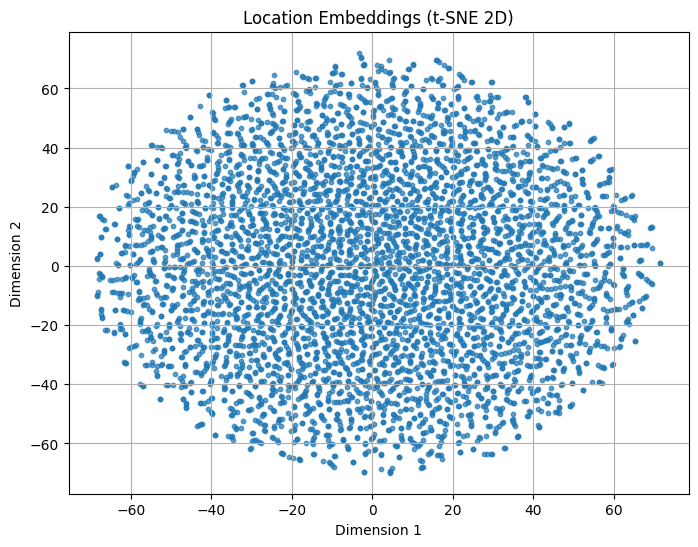

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

embeds_np = loc_embeds[:5000]

tsne = TSNE(n_components=2, random_state=42)
embeds_2d = tsne.fit_transform(embeds_np)

plt.figure(figsize=(8, 6))
plt.scatter(embeds_2d[:, 0], embeds_2d[:, 1], s=10, alpha=0.7)
plt.title("Location Embeddings (t-SNE 2D)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

# Split balanceado e fixo
X_train, X_test, y_train, y_test = train_test_split(
    loc_embeds, categories.ravel(), test_size=0.2, random_state=42, stratify=categories
)

# Escalonamento é importante para embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Classificador linear com regularização leve
clf = LogisticRegression(max_iter=2000, C=1.0, class_weight='balanced', n_jobs=-1)
clf.fit(X_train, y_train)

# Avaliação
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, digits=3))
